# Deep Convolutional GAN (DCGAN)

Generative Adversarial Networks, or GANs for short, are an approach to **Generative Modeling** using deep learning methods. Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.
- **Generator:** Model that is used to generate new plausible examples from the problem domain.
- **Discriminator:** Model that is used to classify examples as real (from the domain) or fake (generated).

**Application of GANs:**
* Generate Examples for Image Datasets(i.e, medical data such as X-ray, MRI)
* Super Resolution
* Clothing Translation
* 3D Object Generation
* Text-to-Image Translation


Here is the implementation of a **Deep Convolutional GAN(DCGAN)** on MNIST dataset.
In this Notebook, we will see how to,
   * Load torchvision dataset
   * Create Generator network
   * Create Discriminator network
   * Train GAN
   * Evaluate GAN during training by plotting results of Generator

## Import Packages

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
# Function to visualizing images from tensor

def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Load data

In these cells we are going to load MNIST dataset from torchvision datasets and apply transforms and creating Dataloader. After that visualization has been done so we can be familier with the dataset.

DCGAN is a very successful and influential GAN model developed in 2015. Most GANs today are at least loosely based on the DCGAN architecture.


Here are the main features of DCGAN:
*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation
*   Both Generator and Discriminator use 4 layers as 3 hidden layers and 1 output layer


In [ ]:
# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


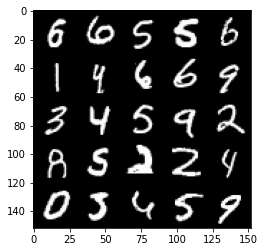

In [ ]:
# Display images from train_loader

dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

## Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Generator of DCGAN, corresponding to
            - Transposed Convolution
            - Batchnorm (except for in the last layer)
            - Activation
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)
        # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)


## Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Discriminator of DCGAN, corresponding to
            - Convolution
            - Batchnorm (except for in the last layer)
            - LeakyReLU activation with 0.2 slope of the leak
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride)
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)
        # returns 1-dimension tensor representing fake/real

## Initialize Generator and Discriminator

In [ ]:
# required parameters for training

z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

## Define loss and Optimizer 

In [ ]:
beta_1 = 0.5         # parameters control the optimizer's momentum
beta_2 = 0.999       # parameters control the optimizer's momentum

G_opt = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))


# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss


## Training

Here's roughly progression of DCGAN. On GPU this takes about 17-18 seconds per thousand steps. On CPU, this can take more than 4 hours per thousand steps.



In [ ]:
display_step = 1000      # how often to display/visualize the images

epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6463983576893818, discriminator loss: 0.7120107425451278


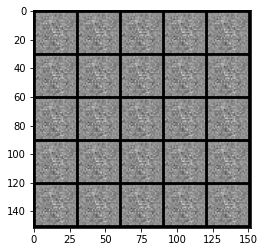

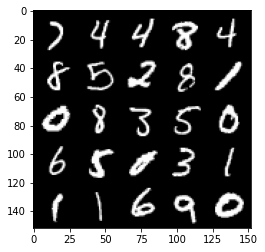

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6432138075232506, discriminator loss: 0.7126863278150567


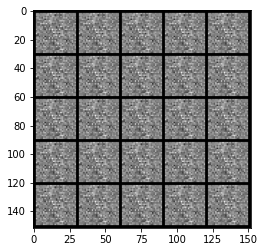

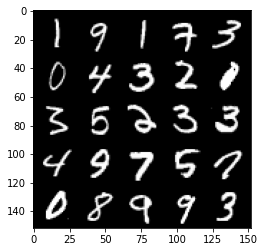

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6429997925162327, discriminator loss: 0.7128063875436786


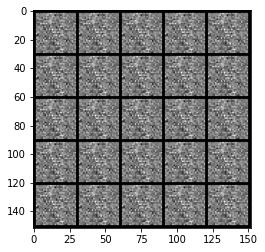

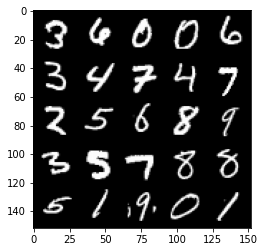

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6429490246176734, discriminator loss: 0.712832852900028


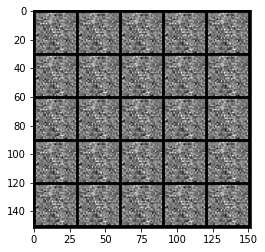

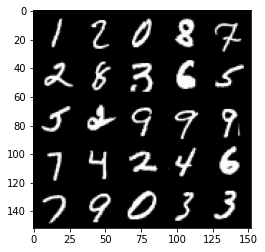

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6429310706853862, discriminator loss: 0.7128441820740686


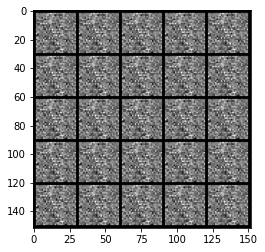

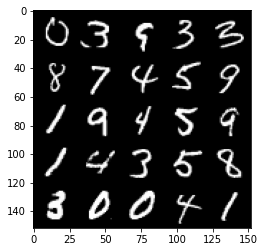

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6429228953719144, discriminator loss: 0.7128473051786425


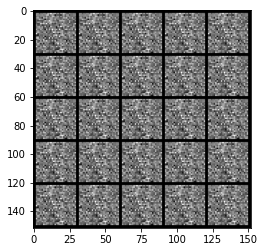

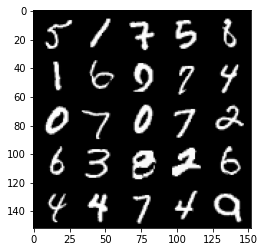

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6429134248495113, discriminator loss: 0.7128546949028968


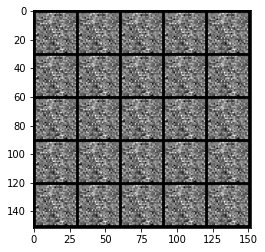

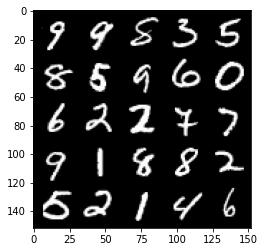

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.642908138334752, discriminator loss: 0.7128558497428887


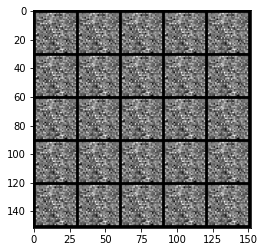

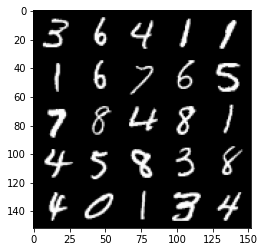

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6429040797352789, discriminator loss: 0.7128596885800368


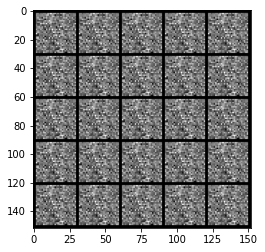

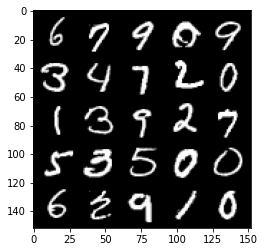

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.6429011071324344, discriminator loss: 0.7128590695858001


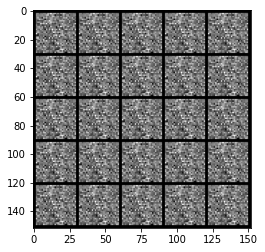

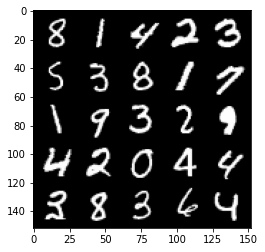

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6428989890217771, discriminator loss: 0.7128634789586072


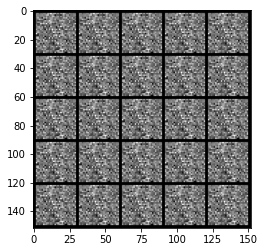

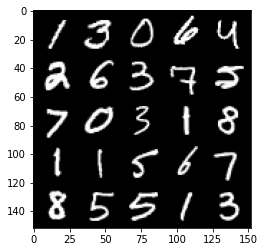

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6428971278667447, discriminator loss: 0.7128629074692723


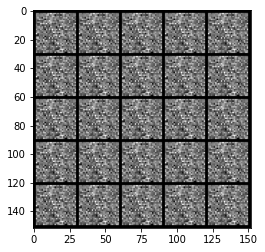

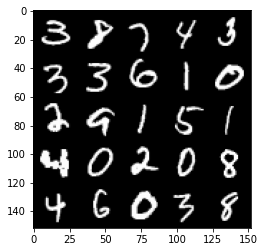

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6428958311080937, discriminator loss: 0.7128606240749362


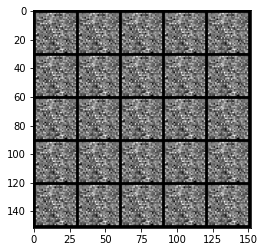

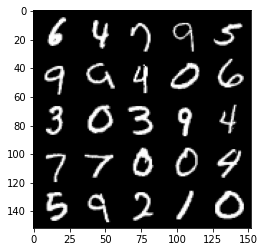

In [ ]:
for epoch in range(epochs):
    for real_img,_ in tqdm(train_loader):

        batch_size = real_img.size(0)
        real_img = real_img.to(device)

        #  Update Discriminator  #
        D_opt.zero_grad()

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)#Generate noise and pass it through the generator
        D_pred = D(fake_img.detach())#Pass real and fake images through the discriminator
        D_fake_loss =  fake_loss(D_pred)#Calculate the loss for the fake images

        D_pred = D(real_img)#Pass real and fake images through the discriminator
        D_real_loss = real_loss(D_pred)#Calculate the loss for the real images
        D_loss = (D_fake_loss + D_real_loss) / 2#Calculate the loss for the discriminator
        mean_discriminator_loss += D_loss.item() / display_step    # Keep track of the average discriminator loss


        #Backward pass for the discriminator

        # Update Generator #
        G_opt.zero_grad()
        #Reset the gradients for the generator
        noise =  torch.randn(batch_size, z_dim, device=device)#Generate noise
        fake_img = G(noise)#Pass noise through the generator
        D_pred = D(fake_img)#Pass fake images through the discriminator
        G_loss = real_loss(D_pred)#Calculate the loss for the generator
        mean_generator_loss += G_loss.item() / display_step     # Keep track of the average generator loss

        #Backward pass for the generator
        G_loss.backward()
        G_opt.step()

        # Visualization #
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_img)
            show_tensor_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


## Create more samples

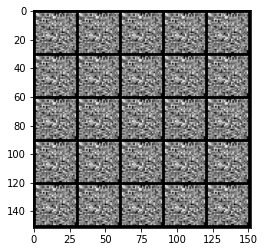

In [ ]:
num_image = 30
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = G(noise)
show_tensor_images(fake_img)